### Checking the count of different classes in the 'outcome' variable

In [1]:
# load and summarize the dataset
import pandas as pd
from collections import Counter
from matplotlib import pyplot

# Define the dataset location
filename = 'train.csv'

train = pd.read_csv(filename)
print(train.shape)
target = train.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k,v, per))

(10000, 10)
Class=0, Count=9018, Percentage=90.180%
Class=1, Count=982, Percentage=9.820%


In [2]:
train.isnull().sum()

age                             0
cost_of_ad                      0
device_type                     0
gender                        269
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
outcome                         0
dtype: int64

### Here, there are some null values in the 'gender' column which is being dropped before further analysis

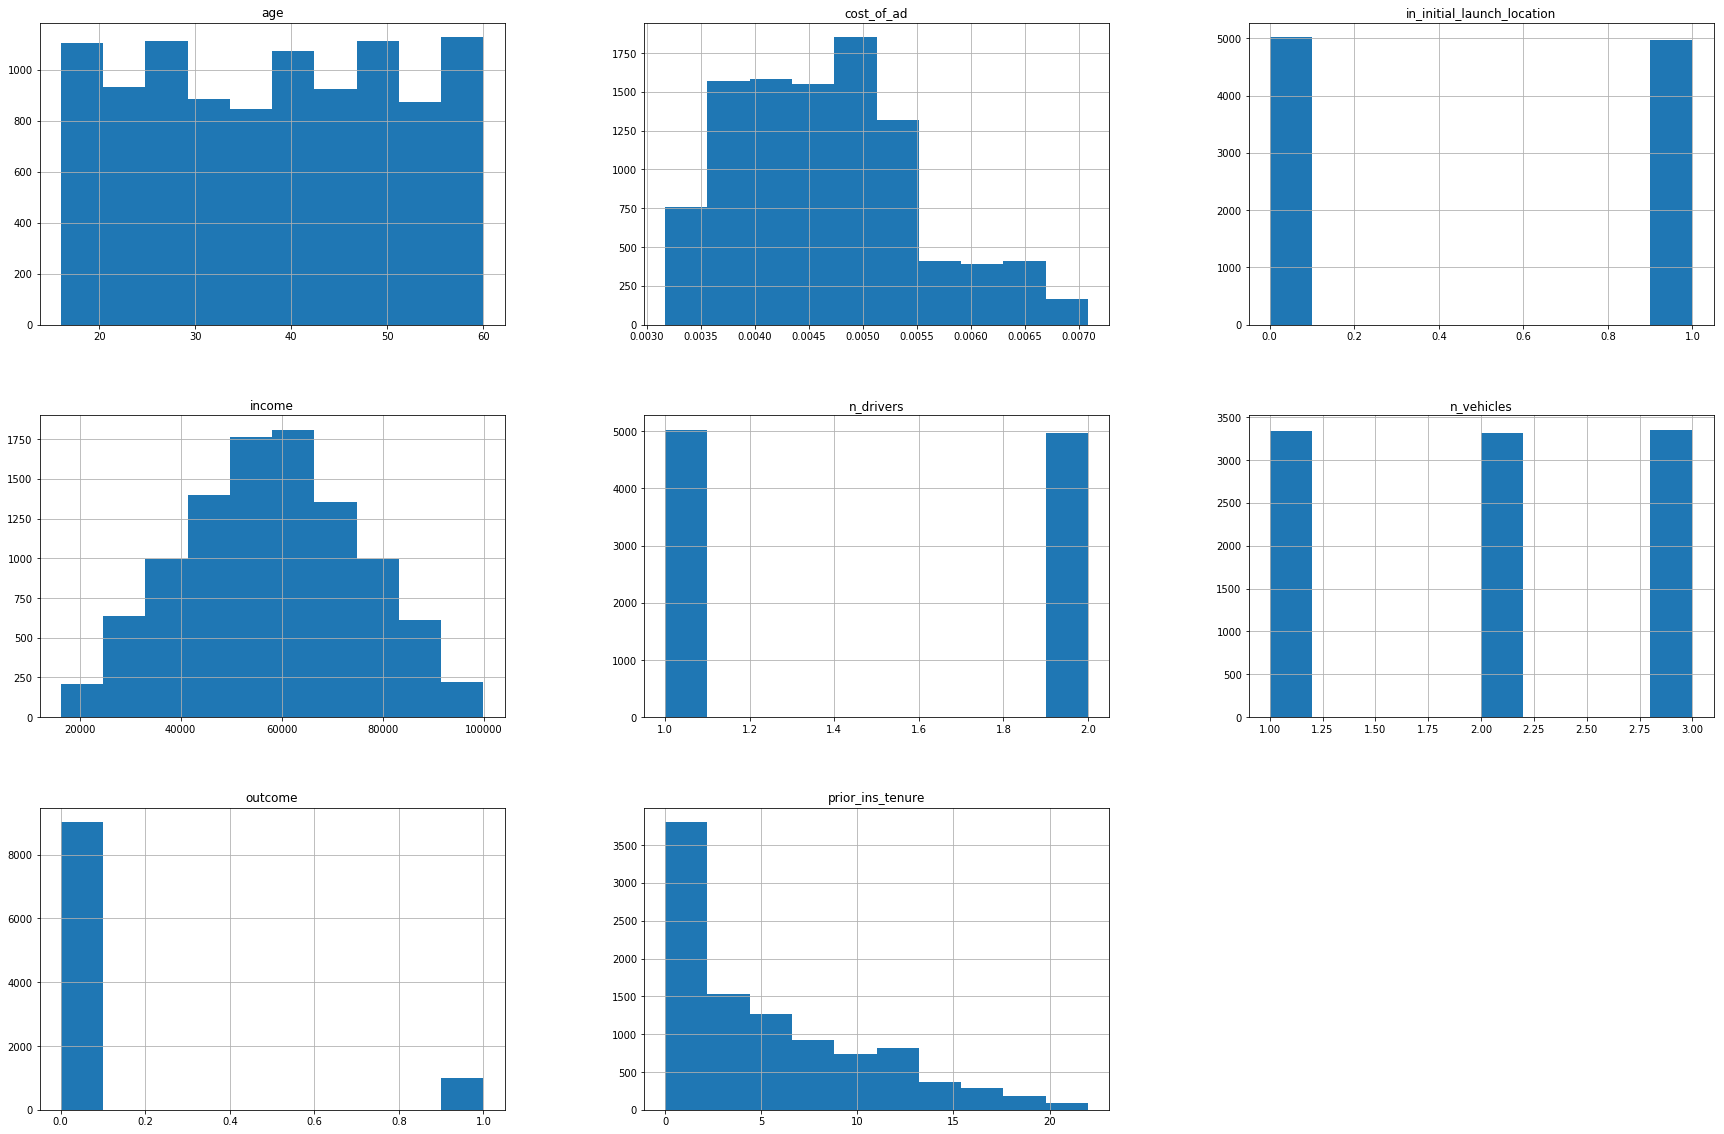

In [3]:
train.hist(figsize=(30,20))
pyplot.show()

### From the above histogram plots of different columns, we get to know that there are some columns which are in different ranges. Normalizing them within a particular range would be better for linear ML algorithms like Logistic Regression and SVM's.

### I have used MinMaxScaler on some columns to bring them in a range of [0,1] and LabelEncoder on 'n_drivers' column for changing labels of 1,2 to 0,1. Used dummies for two columns to split them to gather more information on categorical data. The only trade off is that the number of columns will increase.

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')
new = pd.read_csv('train.csv')
new.dropna(inplace=True)
new['age'] = MinMaxScaler().fit_transform(new['age'].values.reshape(-1,1))
new['cost_of_ad'] = MinMaxScaler().fit_transform(new['cost_of_ad'].values.reshape(-1,1))
new['income'] = MinMaxScaler().fit_transform(new['income'].values.reshape(-1,1))
new['prior_ins_tenure'] = MinMaxScaler().fit_transform(new['prior_ins_tenure'].values.reshape(-1,1))
new['gender'] = LabelEncoder().fit_transform(new['gender'])
new['device_type'] = LabelEncoder().fit_transform(new['device_type'])
new['n_drivers'] = LabelEncoder().fit_transform(new['n_drivers'])
new = pd.get_dummies(data=new, columns=['device_type','n_vehicles'])

In [23]:
new.tail()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,prior_ins_tenure,outcome,device_type_0,device_type_1,device_type_2,device_type_3,device_type_4,n_vehicles_1,n_vehicles_2,n_vehicles_3,predicted_labels
9994,0.954545,0.196937,1,0,0.951741,0,0.818182,0,1,0,0,0,0,1,0,0,1
9995,0.568182,0.269484,1,0,0.576336,1,0.363636,0,0,1,0,0,0,0,0,1,0
9996,0.772727,0.404005,0,0,0.864863,0,0.000000,0,0,0,0,0,1,0,0,1,0
9997,1.000000,0.161977,1,0,0.855629,1,0.409091,0,0,0,0,0,1,0,1,0,0
9998,0.045455,0.170618,1,0,0.480523,1,0.000000,0,0,0,0,1,0,0,1,0,0


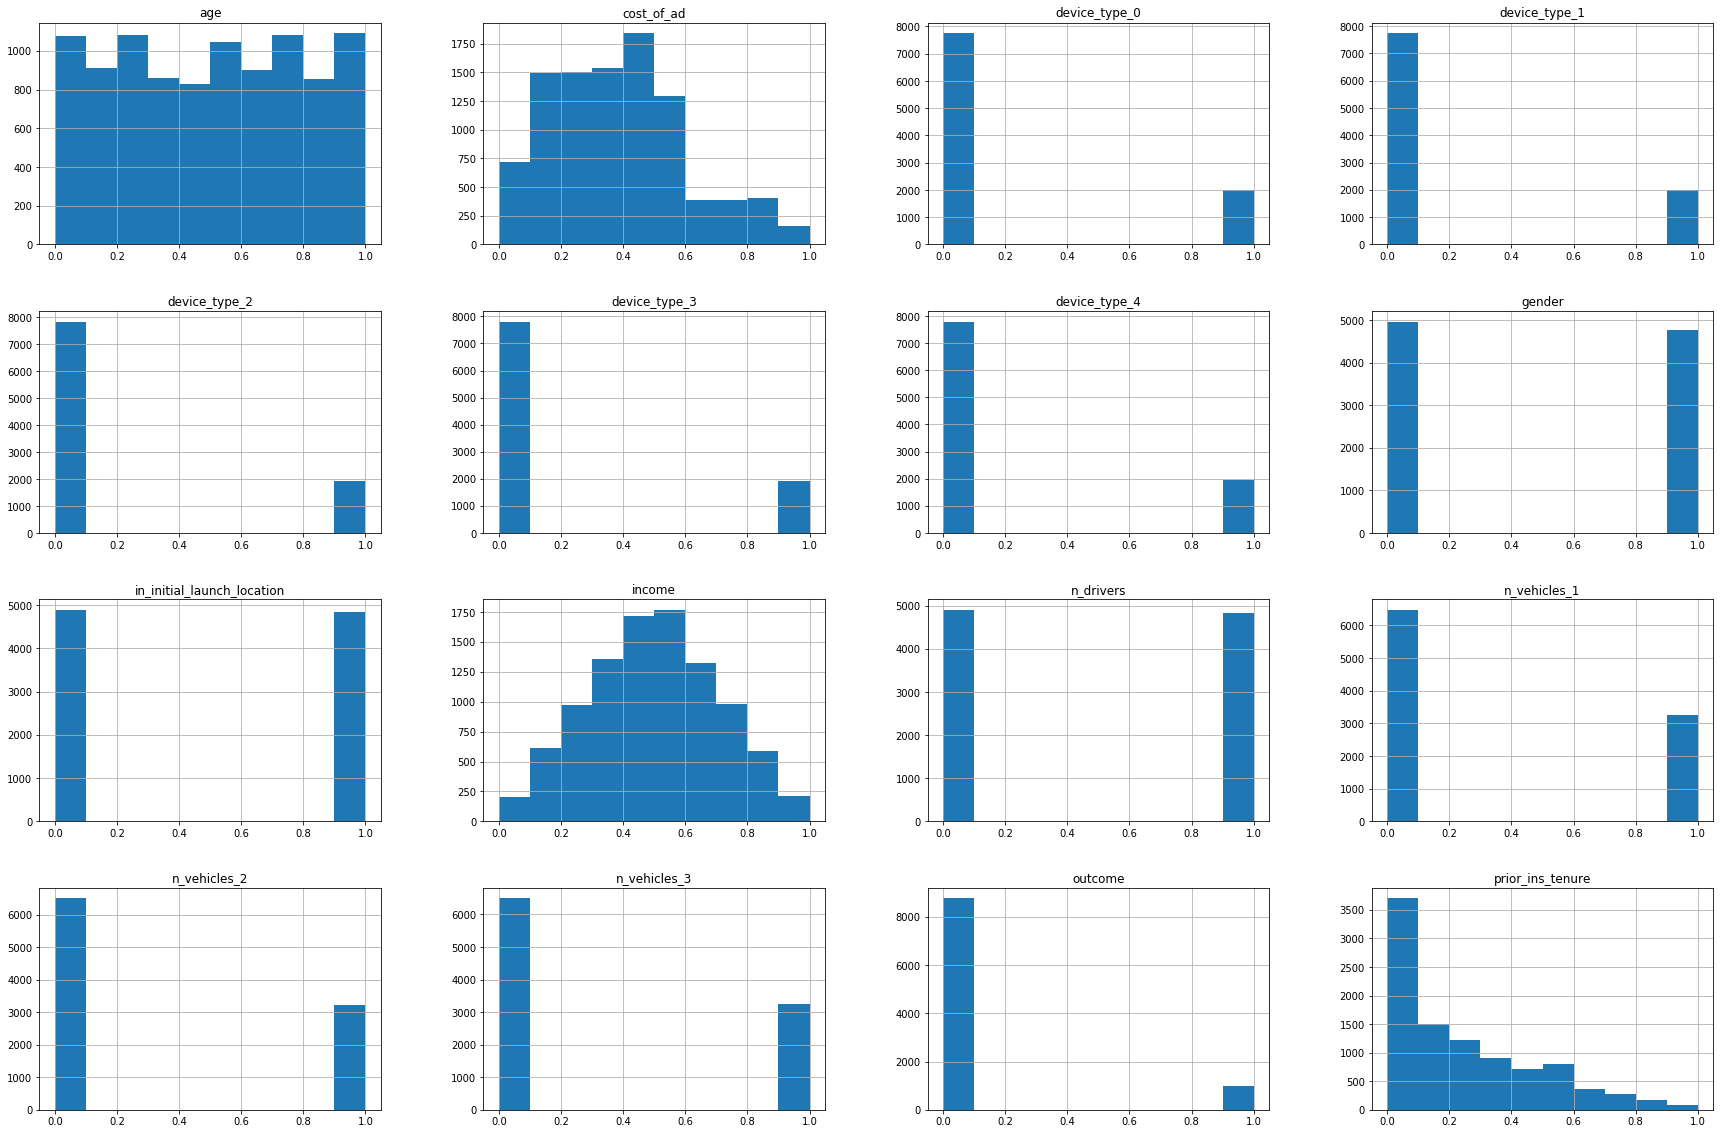

In [6]:
new.hist(figsize=(30,20))
pyplot.show()

### The above histogram plots show that the range  has been taken care of and most of the variables do not have an exponential distribution.

# Baseline Model

### Let us use a baseline model with metric='roc_auc' since we want the auc score. Here, the 0 class is the negative case which has majority class and 1 class is the positive case which is the minority class. Choosing ROC_AUC has the intention to minimize the false positive rate (1 - specificity) and maximize the true positive rate (sensitivity). The use of ROC curves also suggests the desire for a probabilistic model from which an operator can select a probability threshold as the cut-off between acceptable false positive versus true positive rates.

In [7]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
def evaluate_model(X,y,model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
    scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv= cv, n_jobs = -1)
    return scores
new = pd.read_csv('train.csv')
new.dropna(inplace=True)
new['age'] = MinMaxScaler().fit_transform(new['age'].values.reshape(-1,1))
new['cost_of_ad'] = MinMaxScaler().fit_transform(new['cost_of_ad'].values.reshape(-1,1))
new['income'] = MinMaxScaler().fit_transform(new['income'].values.reshape(-1,1))
new['prior_ins_tenure'] = MinMaxScaler().fit_transform(new['prior_ins_tenure'].values.reshape(-1,1))
new['gender'] = LabelEncoder().fit_transform(new['gender'])
new['device_type'] = LabelEncoder().fit_transform(new['device_type'])
new['n_drivers'] = LabelEncoder().fit_transform(new['n_drivers'])
new = pd.get_dummies(data=new, columns=['device_type','n_vehicles'])
X = new.drop(['outcome'], axis=1)
y = new.outcome
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy = 'stratified')
scores = evaluate_model(X, y, model)
print("Mean ROC AUC: %.3f (%.3f)" % (mean(scores), std(scores)))

(9731, 15) (9731,) Counter({0: 8758, 1: 973})
Mean ROC AUC: 0.499 (0.016)


The above baseline model predicts a random class label in proportion to the base rate of each class as ROC AUC of 0.5. This can be considered as no skill classifier and can be achieved by using a DummyClassifier from the scikit learn library.

The general approach is to evaluate candidate models using repeated stratified k-fold cross validation. Choosing k-fold stratified cross validator is useful as it will provide a good estimation of model performance that is not biased. I am using k = 10 which means that each fold will contain 9731/10 = 973 samples. Stratified means that each fold will contain the same mixture of examples by class. In this case, every fold will have 90% 0's and 10% 1's. Repetition indicates that evaluation process will be performed multiple times to  help avoid random results and better capture the variance of the chosen model. Using repeats as 3, which means that single model will be fit and evaluated 10x3 = 30 times with calculated mean and standard deviation of the results will be reported. Here, I am using the scoring metric as roc_auc() function.

# Evaluate Models

>LR 0.815 (0.025)
>SVM 0.793 (0.023)
>BAG 0.819 (0.019)
>RF 0.826 (0.021)
>GBM 0.830 (0.020)


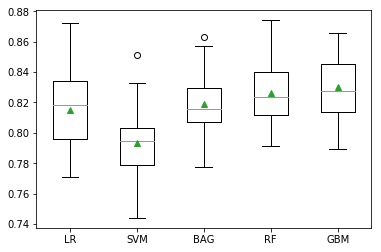

In [8]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='lbfgs'))
    names.append('LR')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # Bagging
    models.append(BaggingClassifier(n_estimators=1000))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=1000))
    names.append('GBM')
    return models,names
X = new.drop(['outcome'],axis=1)
y = new.outcome
models, names = get_models()
results = list()
for i in range(len(models)):
    scores = evaluate_model(X,y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
pyplot.boxplot(results, labels=names, showmeans = True)
pyplot.show()

We use a bunch of classifiers and find the ROC AUC scores as reported above. The best performing model is the GBM (Gradient Boosting Machine). The figure above shows box and whisker plot for each algorithm's sample of results. The box shows the middle 50% of the data, the orange line shows the median of each sample and the green triangle shows the mean of the sample. One thing which can be osberved here is that the mean and median are not that far. The feature space has been scaled before feeding into the models so as to not be unfair to SVM and LR.

# Evaluate cost-sensitive algorithms

Some models can be adapted to pay more attention to one class than the other when fitting a model. There are referred to as cost sensitive algorithms and they can be used for imbalanced classification by specifying a cost that is inversely proportional to the class distribution. For example, with a 90% to 10% distribution, for the majority and the minority class, we can specify to give errors on the minority class a weighting of 90 and errors for majority class a weighting of 10.

>LR 0.817 (0.024)
>SVM 0.854 (0.018)
>RF 0.826 (0.022)


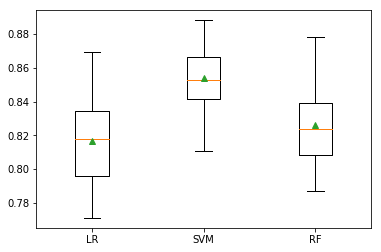

In [9]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
def evaluate_model(X,y,model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
    scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv= cv, n_jobs = -1)
    return scores
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='lbfgs', class_weight='balanced'))
    names.append('LR')
    # SVM
    models.append(SVC(gamma='scale', class_weight='balanced'))
    names.append('SVM')
    # RF
    models.append(RandomForestClassifier(n_estimators=1000))
    names.append('RF')
    return models,names
X = new.drop(['outcome'],axis=1)
y = new.outcome
models, names = get_models()
results = list()
for i in range(len(models)):
    scores = evaluate_model(X,y, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
pyplot.boxplot(results, labels=names, showmeans = True)
pyplot.show()

From the above, we can see that SVM has the highest ROC AUC compared to the cost-insenstive versions. Here, the plot also shows that SVM has a much more compact description than the other two. As such the performance is likely stable and can be considered as  a final model.

# Choosing SVM 

In [10]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
def evaluate_model(X,y,model):
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
    scores = cross_val_score(model, X, y, scoring = 'roc_auc', cv= cv, n_jobs = -1)
    return scores
X = new.drop(['outcome'],axis=1)
y = new.outcome
model  = SVC(gamma='scale', class_weight = 'balanced')
model.fit(X,y)
print('0 Class')
data = new[new['outcome']==0].head()
data = data.drop(['outcome'], axis=1)
data = data.values
for row in data:
    yhat = model.predict([row])
    label = yhat[0]
    print('>Predicted=%d (expected 0)' % (label))
print('1 Class')
data = new[new['outcome']==1].head()
data = data.drop(['outcome'], axis=1)
data = data.values
for row in data:
    yhat = model.predict([row])
    label = yhat[0]
    print('>Predicted=%d (expected 1)' % (label))

0 Class
>Predicted=1 (expected 0)
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=1 (expected 0)
1 Class
>Predicted=0 (expected 1)
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
>Predicted=1 (expected 1)
>Predicted=0 (expected 1)


Some of the predictions of different classes are shown above.

In [11]:
all_labels = []
data = new.drop(['outcome'], axis=1)
data = data.values
for row in data:
    yhat = model.predict([row])
    label = yhat[0]
    all_labels.append(label)
new['predicted_labels'] = all_labels

In [12]:
new.tail(10)

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,prior_ins_tenure,outcome,device_type_0,device_type_1,device_type_2,device_type_3,device_type_4,n_vehicles_1,n_vehicles_2,n_vehicles_3,predicted_labels
9989,0.204545,0.503283,0,1,0.305501,1,0.181818,0,0,0,0,1,0,0,0,1,0
9990,0.204545,0.191627,1,0,0.313492,0,0.181818,0,0,1,0,0,0,0,1,0,1
9991,0.545455,0.515043,0,1,0.502144,1,0.227273,0,0,1,0,0,0,0,0,1,0
9992,0.500000,0.694952,0,1,0.602234,0,0.136364,0,0,0,1,0,0,0,0,1,0
9993,1.000000,0.257948,1,1,0.856943,1,0.818182,1,0,0,0,0,1,1,0,0,1
9994,0.954545,0.196937,1,0,0.951741,0,0.818182,0,1,0,0,0,0,1,0,0,1
9995,0.568182,0.269484,1,0,0.576336,1,0.363636,0,0,1,0,0,0,0,0,1,0
9996,0.772727,0.404005,0,0,0.864863,0,0.000000,0,0,0,0,0,1,0,0,1,0
9997,1.000000,0.161977,1,0,0.855629,1,0.409091,0,0,0,0,0,1,0,1,0,0
9998,0.045455,0.170618,1,0,0.480523,1,0.000000,0,0,0,0,1,0,0,1,0,0


# Predicting Test Data

In [13]:
test = pd.read_csv('test.csv')

In [14]:
test.isnull().sum()

age                             0
cost_of_ad                      0
device_type                     0
gender                        249
in_initial_launch_location      0
income                          0
n_drivers                       0
n_vehicles                      0
prior_ins_tenure                0
dtype: int64

As we can see that there are 249 null values in the 'Gender' column and since we want to predict all the observations, we can randomly impute Male and Female in that column.

In [15]:
test[pd.isnull(test).any(axis=1)].head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure
69,30,0.003440,desktop,NaN,0,68949,1,2,2
78,31,0.003442,other,NaN,0,35738,2,2,5
81,44,0.003662,desktop,NaN,0,71453,1,3,5
109,22,0.003578,Android,NaN,0,25662,2,3,3
222,22,0.003304,Android,NaN,1,51174,1,1,2


In [16]:
import random
def randomiseMissingData(df2):
    "randomise missing data for DataFrame (within a column)"
    df = df2.copy()
    for col in df.columns:
        data = df[col]
        mask = data.isnull()
        samples = random.choices( data[~mask].values , k = mask.sum() )
        data[mask] = samples

    return df

In [17]:
test = randomiseMissingData(test)

In [18]:
test['age'] = MinMaxScaler().fit_transform(test['age'].values.reshape(-1,1))
test['cost_of_ad'] = MinMaxScaler().fit_transform(test['cost_of_ad'].values.reshape(-1,1))
test['income'] = MinMaxScaler().fit_transform(test['income'].values.reshape(-1,1))
test['prior_ins_tenure'] = MinMaxScaler().fit_transform(test['prior_ins_tenure'].values.reshape(-1,1))
test['gender'] = LabelEncoder().fit_transform(test['gender'])
test['device_type'] = LabelEncoder().fit_transform(test['device_type'])
test['n_drivers'] = LabelEncoder().fit_transform(test['n_drivers'])
test = pd.get_dummies(data=test, columns=['device_type','n_vehicles'])

In [19]:
predicted_test_labels = []
data = test.values
for row in data:
    yhat = model.predict([row])
    label = yhat[0]
    predicted_test_labels.append(label)
test['predicted_labels'] = predicted_test_labels

In [20]:
test.head()

,age,cost_of_ad,gender,in_initial_launch_location,income,n_drivers,prior_ins_tenure,device_type_0,device_type_1,device_type_2,device_type_3,device_type_4,n_vehicles_1,n_vehicles_2,n_vehicles_3,predicted_labels
0,0.409091,0.505855,0,1,0.289431,0,0.318182,1,0,0,0,0,0,0,1,0
1,0.840909,0.528996,0,1,0.816152,0,0.500000,0,1,0,0,0,1,0,0,1
2,0.681818,0.455548,0,0,0.754225,0,0.181818,0,0,0,1,0,1,0,0,0
3,0.454545,0.451764,0,0,0.562954,0,0.000000,1,0,0,0,0,0,1,0,0
4,0.272727,0.509075,0,1,0.239235,0,0.136364,0,0,0,0,1,0,0,1,0
